# Bildverarbeitung mit Python
Gert-Ludwig Ingold
<div style="margin-top:10ex;font-size:smaller">Quellen: `git clone https://github.com/gertingold/lit2017`</div>

## Bearbeitung digitaler Bilder unter Linux

 * `darktable`
 * `gimp`
 * ...
 * **hier:** `Python`  
   * skriptbasiert, hohe Reproduzierbarkeit
   * Möglichkeit zur Inspektion des Codes in frei verfügbaren Programmbibliotheken
   * Möglichkeit zum freien Experimentieren
   * Bearbeitung von größeren Bildmengen
   * Auswertung wissenschaftlicher Bilder

## Digitale Bilder sind numerische Daten
![foo](img/imagearrays.png)

→ verwende ndarray von NumPy

## Pythons wissenschaftliches Ökosystem

 1. **NumPy**  
    stellt Arrays und die zugehörige Funktionalität zur Verfügung  
    bildet die Basis für alle weiteren Pakete
 2. **SciPy**  
    umfangreiche wissenschaftliche Programmbibliothek  
    bietet auch grundlegende Unterstützung für Bildverarbeitung
 3. **Matplotlib**  
    wird hier zur Darstellung der Bilder benutzt
 4. **Scikit Image**  
    Scikits sind spezialisierte Erweiterungen zu SciPy  
    Scikit Image konzentriert sich auf die Bildverarbeitung
 5. **+ ...**

### SciPy Lecture Notes
#### `www.scipy-lectures.org`
![foo](img/ScipyLectCover.png)

* Verwendete Pakete
  * `NumPy` und `SciPy`  
    http://scipy.org
  * `matplotlib`  
    http://matplotlib.org
  * `scikit-image`  
    http://scikit-image.org

* Die Quellen aller Pakete sind auf Github verfügbar.

* Python-Distribution mit allem was man hier braucht:
  * `Anaconda`  
    http://continuum.io

### Die Zutaten

In [1]:
%matplotlib inline
import numpy as np
from scipy import misc, ndimage
import matplotlib.pyplot as plt
from skimage import color, data, draw, exposure, filters, measure, transform

### Unser Wegbegleiter

In [ ]:
plt.imshow(misc.face())

## Speichern und Lesen eines Bildes

In [ ]:
misc.imsave('face.png', misc.face())

### Bilddaten im PNG-Format

In [ ]:
with open('face.png', 'rb') as file:
    print(file.read(20))

### Bilddaten als NumPy-Array

In [2]:
waschbär = misc.imread('face.png')

In [ ]:
type(waschbär)

In [ ]:
waschbär.shape

In [ ]:
waschbär

## Schwarz-Weiß-Bilder

In [20]:
waschbär_sw = misc.face(gray=True)

In [ ]:
waschbär_sw

In [ ]:
plt.imshow(waschbär_sw)

Standardfarbskala von Matplotlib: `cm.viridis`

für Schwarz-Weiß-Bilder besser: `cm.gray`

In [ ]:
plt.imshow(waschbär_sw, cmap=plt.cm.gray)

## Bearbeitung mit Standard-NumPy-Methoden

### Rahmung eines Bildes

In [ ]:
gerahmtes_bild = np.zeros_like(waschbär_sw)
rand = 20
gerahmtes_bild[rand:-rand, rand:-rand] = waschbär_sw[rand:-rand, rand:-rand]
plt.imshow(gerahmtes_bild, cmap=plt.cm.gray)

* mit Nullen gefülltes Array bedeutet schwarze Fläche
* Einblenden eines Teilbildes unter Verwendung der Slicing-Syntax  
  (vergleiche Slicing bei Python-Listen)

### Veränderung des Farbtons

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.24, 7.68))
ax0.imshow(np.array(waschbär_sw[:, :, np.newaxis]*np.array([0.9, 0.9, 1.0]),
                    dtype=np.uint8))
ax1.imshow(waschbär_sw, cmap=plt.cm.gray)

* Schwarz-Weiß-Bild wird in Farbbild umgewandelt  
  → eine dritte Achse muss hinzugefügt werden (`np.newaxis`)
* NumPy Broadcasting: der RGB-Wert wird in die dritte Achse eingefügt  
  → Verstärkung des Blaukanals im Vergleich zum rechten Originalbild

### Maskierung eines Bildes

In [ ]:
maskierter_waschbär = waschbär_sw[:, :]
centerx, centery = 660, 300
radius = 230
sy, sx = waschbär_sw.shape
y, x = np.ogrid[:sy, :sx]
maske = ((y-centery)**2 + (x-centerx)**2) > radius**2
maskierter_waschbär[maske] = 0
plt.imshow(maskierter_waschbär, cmap=plt.cm.gray)

* Maske enthält Wahrheitswerte  
  `True`: Punkt liegt außerhalb des gewählten Kreises  
  `False`: Punkt liegt innerhalb des gewählten Kreises
* Adressierung mit booleschem Array (`maske`)

### Maskierung mit Scikit Image

#### Beispiel: Ellipse

In [3]:
help(draw.ellipse)

Help on function ellipse in module skimage.draw.draw:

ellipse(r, c, yradius, xradius, shape=None)
    Generate coordinates of pixels within ellipse.
    
    Parameters
    ----------
    r, c : double
        Centre coordinate of ellipse.
    yradius, xradius : double
        Minor and major semi-axes. ``(x/xradius)**2 + (y/yradius)**2 = 1``.
    shape : tuple, optional
        Image shape which is used to determine the maximum extent of output pixel
        coordinates. This is useful for ellipses which exceed the image size.
        By default the full extent of the ellipse are used.
    
    Returns
    -------
    rr, cc : ndarray of int
        Pixel coordinates of ellipse.
        May be used to directly index into an array, e.g.
        ``img[rr, cc] = 1``.
    
    Examples
    --------
    >>> from skimage.draw import ellipse
    >>> img = np.zeros((10, 10), dtype=np.uint8)
    >>> rr, cc = ellipse(5, 5, 3, 4)
    >>> img[rr, cc] = 1
    >>> img
    array([[0, 0, 0, 0, 0, 0,

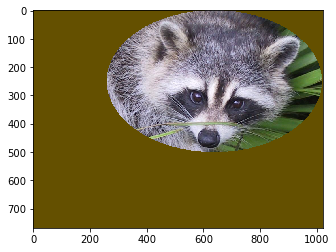

In [4]:
maskierter_waschbär = np.ones_like(waschbär)*np.array([100, 80, 0], dtype=np.uint8)
e_rr, e_cc = draw.ellipse(250, 640, 250, 380, shape=waschbär.shape)
maskierter_waschbär[e_rr, e_cc, :] = waschbär[e_rr, e_cc, :]
plt.imshow(maskierter_waschbär)

## Transformationen

* aus `scipy.ndimage`
* interpoliert bei Bedarf

### Verschiebung

In [ ]:
plt.imshow(ndimage.shift(waschbär, (100, 50, 0)))

### Zoom

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
ax0.imshow(ndimage.zoom(waschbär, (2, 2, 1))[-250:, :250])
ax1.imshow(waschbär[-250:, :250])

### Drehung

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 8))
ax0.imshow(ndimage.rotate(waschbär, 30))
ax1.imshow(ndimage.rotate(waschbär, 30, reshape=False))

### Stürzende Linien

In [ ]:
lille = misc.imread('img/lille.png')
plt.imshow(lille, cmap=plt.cm.gray)

In [ ]:
def mapfunc(output_coords, *args):
    xp, yp = output_coords
    xmax, ymax = args[0]
    fak = args[1]
    yorig = (yp-(1-fak)*xp/xmax*0.5*ymax)/(fak+(1-fak)*(1-xp/xmax))
    return (xp, yorig)

lille_trafo = ndimage.geometric_transform(lille, mapping=mapfunc,
                                          extra_arguments=(lille.shape, 0.74))

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 8))
ax0.imshow(lille, cmap=plt.cm.gray)
ax1.imshow(lille_trafo, cmap=plt.cm.gray)
ax2.imshow(lille_trafo[:, 120:780], cmap=plt.cm.gray)

### Der exponentierte Waschbär

In [ ]:
def mapfunc(output_coords, *args):
    xp, yp, zp = output_coords
    xmax, ymax, _ = args[0]
    xp = 3-6*xp/xmax
    yp = 3-6*yp/ymax
    xorig = 0.5*xmax*(1-np.log(xp**2+yp**2+1e-12)/(2*np.pi))
    yorig = 0.5*ymax*(1+np.arctan2(xp, yp)/np.pi)
    return (xorig, yorig, zp)

plt.imshow(ndimage.geometric_transform(waschbär, mapping=mapfunc,
                                       extra_arguments=(waschbär.shape,)))

### Bestimmung der Transformationsparameter mit Hilfe von Scikit Image

* Rückgängigmachung einer projektiven Verzerrung

In [ ]:
text = data.text()
plt.imshow(text, cmap=plt.cm.gray)

* Festlegung von Referenzpunkten

In [ ]:
dst = np.array([[155, 15], [65, 40], [260, 130], [360, 95]])
plt.imshow(text, cmap=plt.cm.gray)
plt.plot(dst[:, 0], dst[:, 1], '.r')

* Festlegung der Bildpunkte
* Durchführung der Transformation

In [ ]:
src = np.array([[0, 0], [0, 50], [300, 50], [300, 0]])

tform = transform.ProjectiveTransform()
tform.estimate(src, dst)
warped = transform.warp(text, tform, output_shape=(50, 300))

plt.imshow(warped, cmap=plt.cm.gray)

## Farbmarkierung von Bildelementen

#### Verteilung der Farbkanäle

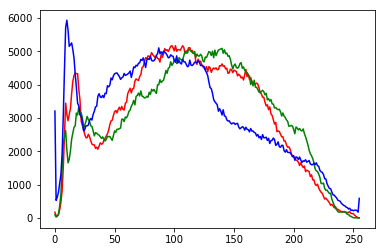

In [5]:
for column, farbe in enumerate(('r', 'g', 'b')):
    plt.plot(ndimage.histogram(waschbär[:, :, column], min=0, max=255, bins=256), farbe)

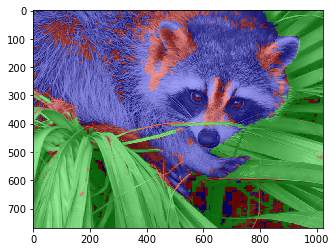

In [6]:
label = np.zeros(shape=waschbär.shape[:2])
label[np.logical_and(waschbär[:, :, 1] > waschbär[:, :, 0], waschbär[:, :, 1] > waschbär[:, :, 2])] = 1
label[np.logical_and(waschbär[:, :, 2] > waschbär[:, :, 0], waschbär[:, :, 2] > waschbär[:, :, 1])] = 2
colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
rgb = color.colorlabel.label2rgb(label, image=waschbär, colors=colors, alpha=0.35, image_alpha=1)
plt.imshow(rgb)

## Messung von Farbabständen

* Umwandlung in den Lab-Farbraum

In [9]:
grün = color.colorconv.rgb2lab(np.array([0, 255, 0], dtype=np.uint8).reshape(1, 1, 3))

In [11]:
waschbär_lab = color.colorconv.rgb2lab(waschbär)

* Bestimmung des Farbabstands zur Referenzfarbe

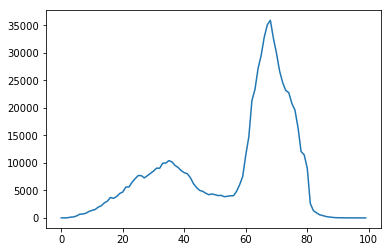

In [13]:
diff = color.delta_e.deltaE_cie76(waschbär_lab, grün)
plt.plot(ndimage.histogram(diff, min=np.min(diff), max=np.max(diff), bins=100))

* Entfernung grüner Bildbereiche

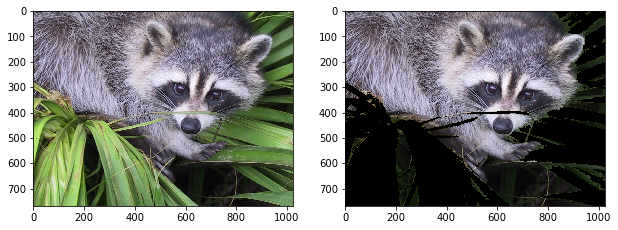

In [15]:
schwelle = 115
waschbär_ohne_grün = np.zeros_like(waschbär)
waschbär_ohne_grün[diff > schwelle] = waschbär[diff > schwelle]
fig1, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.24, 7.68))
ax0.imshow(waschbär)
ax1.imshow(waschbär_ohne_grün)

## Komplexere Beispiele

Quelle: Scikit Image Gallery (http://scikit-image.org/docs/dev/auto_examples/)

/opt/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


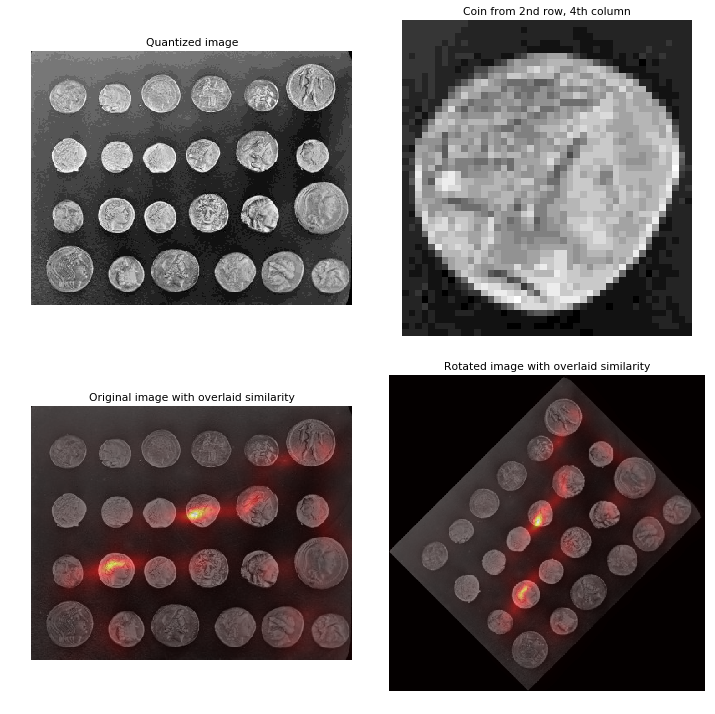

In [28]:
from __future__ import division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from skimage import data, transform
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from skimage.filters import rank


matplotlib.rcParams['font.size'] = 9


def windowed_histogram_similarity(image, selem, reference_hist, n_bins):
    # Compute normalized windowed histogram feature vector for each pixel
    px_histograms = rank.windowed_histogram(image, selem, n_bins=n_bins)

    # Reshape coin histogram to (1,1,N) for broadcast when we want to use it in
    # arithmetic operations with the windowed histograms from the image
    reference_hist = reference_hist.reshape((1, 1) + reference_hist.shape)

    # Compute Chi squared distance metric: sum((X-Y)^2 / (X+Y));
    # a measure of distance between histograms
    X = px_histograms
    Y = reference_hist

    num = (X - Y) ** 2
    denom = X + Y
    denom[denom == 0] = np.infty
    frac = num / denom

    chi_sqr = 0.5 * np.sum(frac, axis=2)

    # Generate a similarity measure. It needs to be low when distance is high
    # and high when distance is low; taking the reciprocal will do this.
    # Chi squared will always be >= 0, add small value to prevent divide by 0.
    similarity = 1 / (chi_sqr + 1.0e-4)

    return similarity


# Load the `skimage.data.coins` image
img = img_as_ubyte(data.coins())

# Quantize to 16 levels of greyscale; this way the output image will have a
# 16-dimensional feature vector per pixel
quantized_img = img // 16

# Select the coin from the 4th column, second row.
# Co-ordinate ordering: [x1,y1,x2,y2]
coin_coords = [184, 100, 228, 148]   # 44 x 44 region
coin = quantized_img[coin_coords[1]:coin_coords[3],
                     coin_coords[0]:coin_coords[2]]

# Compute coin histogram and normalize
coin_hist, _ = np.histogram(coin.flatten(), bins=16, range=(0, 16))
coin_hist = coin_hist.astype(float) / np.sum(coin_hist)

# Compute a disk shaped mask that will define the shape of our sliding window
# Example coin is ~44px across, so make a disk 61px wide (2 * rad + 1) to be
# big enough for other coins too.
selem = disk(30)

# Compute the similarity across the complete image
similarity = windowed_histogram_similarity(quantized_img, selem, coin_hist,
                                           coin_hist.shape[0])

# Now try a rotated image
rotated_img = img_as_ubyte(transform.rotate(img, 45.0, resize=True))
# Quantize to 16 levels as before
quantized_rotated_image = rotated_img // 16
# Similarity on rotated image
rotated_similarity = windowed_histogram_similarity(quantized_rotated_image,
                                                   selem, coin_hist,
                                                   coin_hist.shape[0])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

axes[0, 0].imshow(quantized_img, cmap='gray')
axes[0, 0].set_title('Quantized image')
axes[0, 0].axis('off')

axes[0, 1].imshow(coin, cmap='gray')
axes[0, 1].set_title('Coin from 2nd row, 4th column')
axes[0, 1].axis('off')

axes[1, 0].imshow(img, cmap='gray')
axes[1, 0].imshow(similarity, cmap='hot', alpha=0.5)
axes[1, 0].set_title('Original image with overlaid similarity')
axes[1, 0].axis('off')

axes[1, 1].imshow(rotated_img, cmap='gray')
axes[1, 1].imshow(rotated_similarity, cmap='hot', alpha=0.5)
axes[1, 1].set_title('Rotated image with overlaid similarity')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

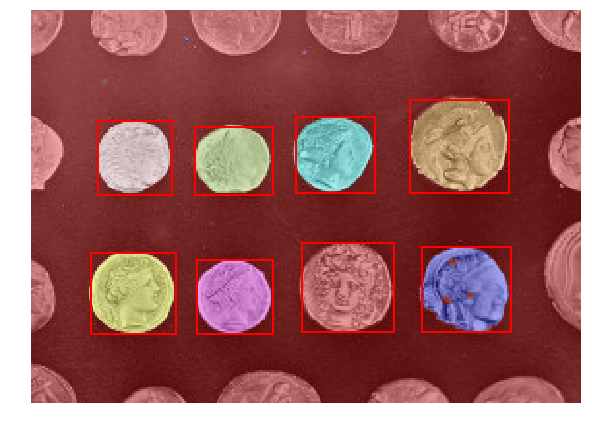

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb


image = data.coins()[50:-50, 50:-50]

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=image)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()